# Loading Data

In [4]:
# https://www.figure-eight.com/data-for-everyone/

In [5]:
# pip install requests
import requests

# Old URL for the dataset 
# url = 'https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Airline-Sentiment-2-w-AA.csv'

# New version of the data here
# https://github.com/ClimbsRocks/nlpSentiment

url = 'https://raw.githubusercontent.com/ClimbsRocks/nlpSentiment/master/twitterCorpus/Airline-Sentiment-2-w-AA.csv'
data = requests.get(url)

In [6]:
from io import StringIO

df = pd.read_csv(StringIO(data.text), sep=",") 

In [7]:
df.columns

Index(['_unit_id', '_golden', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'airline_sentiment',
       'airline_sentiment:confidence', 'negativereason',
       'negativereason:confidence', 'airline', 'airline_sentiment_gold',
       'name', 'negativereason_gold', 'retweet_count', 'text', 'tweet_coord',
       'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone'],
      dtype='object')

In [8]:
df.shape

(14640, 20)

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


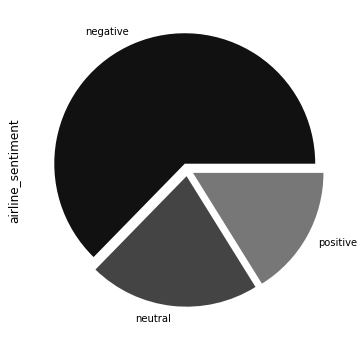

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

explode = (0.05, 0.05, 0.05)
colors = ['#111111', '#444444', '#777777']
df['airline_sentiment'].value_counts().plot(kind='pie', colors=colors, explode=explode, ax=ax)

fig.show()

In [10]:
df['airline_sentiment'].value_counts() / df['airline_sentiment'].shape[0]

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

In [11]:
df['negativereason'].value_counts() / df['airline_sentiment'].shape[0]

Customer Service Issue         0.198770
Late Flight                    0.113730
Can't Tell                     0.081284
Cancelled Flight               0.057855
Lost Luggage                   0.049454
Bad Flight                     0.039617
Flight Booking Problems        0.036134
Flight Attendant Complaints    0.032855
longlines                      0.012158
Damaged Luggage                0.005055
Name: negativereason, dtype: float64

In [12]:
pd.options.display.max_colwidth = 90

In [13]:
df[['text', 'airline', 'airline_sentiment:confidence', 'airline_sentiment']].sample(5)

,text,airline,airline_sentiment:confidence,airline_sentiment
1328,@united Any news about the departure of the flight UA51?,United,0.6657,neutral
4530,@SouthwestAir in flight wifi + @TMobile wifi calling makes for the best combination. W...,Southwest,1.0000,positive
2191,@united what's the best way to get your tickets? Print off at home or go to check in d...,United,1.0000,neutral
13382,@AmericanAir @andyellwood @delk lol. I was sure I'd wake up to more of a response than...,American,1.0000,negative
9174,@USAirways you took the miles out of my account and told me that I could restore by p...,US Airways,1.0000,negative


In [14]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df)

In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y_train = le.fit_transform(df_train['airline_sentiment'])
y_test = le.transform(df_test['airline_sentiment'])

# y_train = df_train['airline_sentiment']
# y_test = df_test['airline_sentiment']

In [16]:
le.classes_.tolist()

['negative', 'neutral', 'positive']

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [18]:
pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

,token
id,
0,00
1,00 pm
2,000
3,000 miles
4,00pm
...,...
18454,yup
18455,yvr
18456,yyz


In [19]:
x_train

<10980x18459 sparse matrix of type '<class 'numpy.int64'>'
	with 283426 stored elements in Compressed Sparse Row format>

In [20]:
x_test

<3660x18459 sparse matrix of type '<class 'numpy.int64'>'
	with 88468 stored elements in Compressed Sparse Row format>

In [21]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=True)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
).round(2)

,Precision,Recall,F,Support
negative,0.85,0.90,0.88,2331
neutral,0.68,0.58,0.63,742
positive,0.74,0.71,0.72,587


In [22]:
pd.Series(p).round(2)

0    0.85
1    0.68
2    0.74
dtype: float64

In [23]:
pd.Series(p).round(2).mean()

0.7566666666666667

In [24]:
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 75.87% & Recall=73.09%


In [25]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.807103825136612

In [26]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.882713,0.865294,0.873917,2331
neutral,0.635374,0.629380,0.632363,742
positive,0.693750,0.756388,0.723716,587


In [27]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.8000000000000002

Micro FScore = 0.7795081967213114 @ ngram_range = (1, 1)
Micro FScore = 0.7303278688524591 @ ngram_range = (2, 2)
Micro FScore = 0.6346994535519126 @ ngram_range = (3, 3)
Micro FScore = 0.659016393442623 @ ngram_range = (4, 4)
Micro FScore = 0.6524590163934426 @ ngram_range = (5, 5)
Micro FScore = 0.646448087431694 @ ngram_range = (6, 6)
Micro FScore = 0.6456284153005465 @ ngram_range = (7, 7)
Micro FScore = 0.6396174863387978 @ ngram_range = (8, 8)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


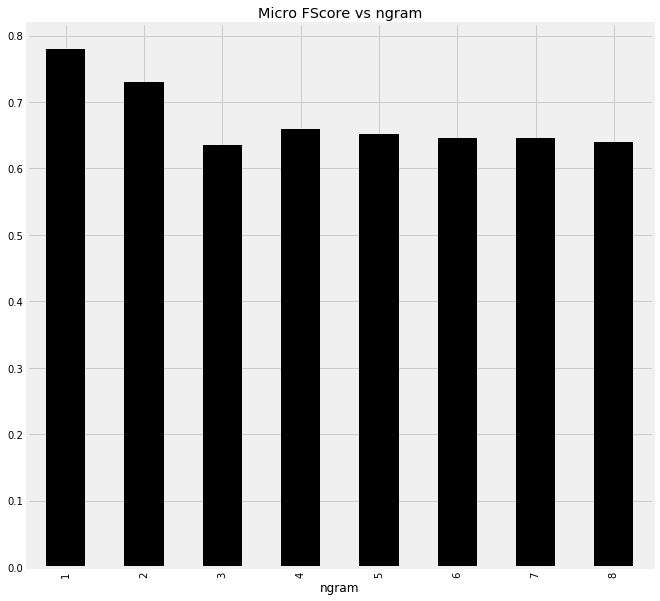

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

micro_fscores = []

for ngram_range in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=ngram_range, min_df=3, max_df=0.2, strip_accents='ascii'),
        MultinomialNB(fit_prior=False)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

    micro_fscore = precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

    print(f'Micro FScore = {micro_fscore} @ ngram_range = {ngram_range}')
    
    micro_fscores.append([ngram_range[-1], micro_fscore])
    
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

pd.DataFrame(
    micro_fscores,
    columns=['ngram', 'Micro FScore']
).set_index('ngram')['Micro FScore'].plot(
    title='Micro FScore vs ngram',
    color='k',
    kind='bar',
    ax=ax,
)

fig.show()

/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


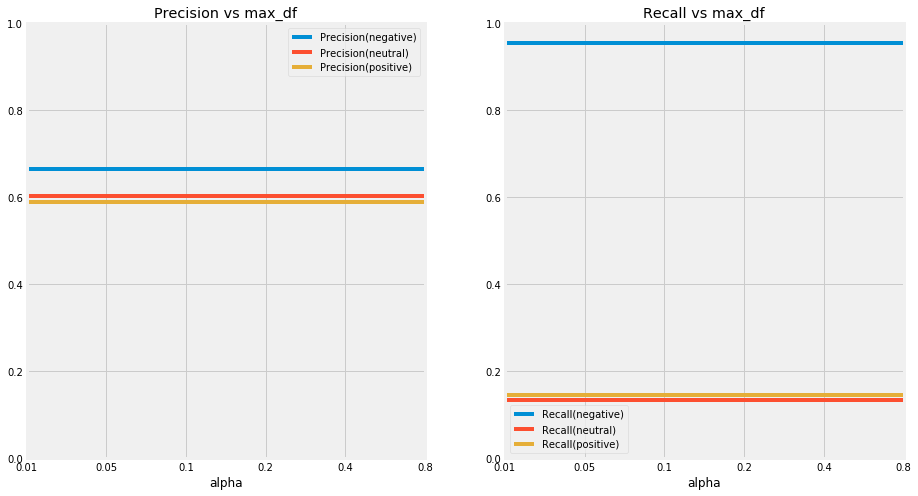

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

precision_scores = []
recall_scores = []

for max_df in [.01, .05, .1, .2, .4, .8]:

    pipeline = make_pipeline(
        CountVectorizer(ngram_range=(4,4), min_df=3, max_df=max_df, strip_accents='ascii'),
        MultinomialNB(fit_prior=False, alpha=1)
    )

    pipeline.fit(df_train['text'], y_train)
    y_test_pred =  pipeline.predict(df_test['text'])

    p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)
    
    precision_score = [f'{max_df}']
    precision_score.extend(p)
    
    recall_score = [f'{max_df}']
    recall_score.extend(r)
    
    precision_scores.append(precision_score)
    recall_scores.append(recall_score)
    
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

pd.DataFrame(
    precision_scores,
    columns=['alpha', 'Precision(negative)', 'Precision(neutral)', 'Precision(positive)']
).set_index('alpha').plot(
    title='Precision vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[0],
)

pd.DataFrame(
    recall_scores,
    columns=['alpha', 'Recall(negative)', 'Recall(neutral)', 'Recall(positive)']
).set_index('alpha').plot(
    title='Recall vs max_df',
    # color='k',
    kind='line',
    ylim=(0,1),
    ax=axs[1],
)

fig.show()

# GridSearch + Pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

pipe = Pipeline(steps=[('CountVectorizer', CountVectorizer()), ('MultinomialNB', MultinomialNB())])

In [31]:
param_grid = {
    'CountVectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'MultinomialNB__alpha': [0.1, 1],
    'MultinomialNB__fit_prior': [True, False],
}

In [32]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='precision_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 2), 'MultinomialNB__alpha': 1, 'MultinomialNB__fit_prior': True}


In [33]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 82.27% & Recall=56.37%


In [34]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='recall_macro', n_jobs=-1)
search.fit(df_train['text'], y_train)
print(search.best_params_)

{'CountVectorizer__ngram_range': (1, 1), 'MultinomialNB__alpha': 0.1, 'MultinomialNB__fit_prior': False}


In [35]:
y_test_pred = search.predict(df_test['text'])

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred, average='macro')

print(f'Macro Precision = {p:.2%} & Recall={r:.2%}')

Macro Precision = 71.27% & Recall=72.55%


In [36]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(ngram_range=(1,3), min_df=3, max_df=0.2, binary=True, strip_accents='ascii')

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [37]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import BernoulliNB

clf = BernoulliNB(fit_prior=False)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.898618,0.836551,0.866474,2331
neutral,0.586359,0.718329,0.645669,742
positive,0.721170,0.713799,0.717466,587


In [38]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.7928961748633879

In [39]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [40]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
9673,my,-1.475578,-1.922449,-1.994307
7755,is,-1.562241,-1.934111,-2.359280
7446,in,-1.738453,-1.937047,-2.045165
7999,it,-1.865834,-2.000802,-2.076073
10543,of,-1.877219,-2.277055,-2.335750
10266,not,-1.965967,-3.021061,-3.372371
13877,that,-1.999904,-2.589843,-2.570590
18305,your,-2.021715,-3.003819,-2.301461
13121,southwestair,-2.030575,-1.547393,-1.387420


In [41]:
df_vocab.sort_values('positive_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
13825,thanks,-3.363798,-2.986870,-1.380686
13121,southwestair,-2.030575,-1.547393,-1.387420
8203,jetblue,-2.262377,-1.474424,-1.442990
13801,thank,-4.704724,-3.795701,-1.696347
13805,thank you,-4.842874,-3.834167,-1.737041
9673,my,-1.475578,-1.922449,-1.994307
7446,in,-1.738453,-1.937047,-2.045165
7999,it,-1.865834,-2.000802,-2.076073
3385,co,-3.008812,-1.860631,-2.230971


In [42]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


/Users/tarek/anaconda3/envs/scikitbook/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Precision,Recall,F,Support
negative,0.864820,0.897469,0.880842,2331
neutral,0.633472,0.617251,0.625256,742
positive,0.776062,0.684838,0.727602,587


In [43]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[2]

0.8065573770491803

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,3), sublinear_tf=True)

x_train = vec.fit_transform(df_train['text'])
x_test = vec.transform(df_test['text'])

In [45]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB(fit_prior=False, alpha=0.001)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)

,Precision,Recall,F,Support
negative,0.814216,0.928786,0.867735,2331
neutral,0.660985,0.470350,0.549606,742
positive,0.750529,0.604770,0.669811,587


In [46]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.783879781420765

In [47]:
df_vocab = pd.DataFrame(vec.vocabulary_.items(), columns=['token', 'id']).sort_values('id').set_index('id')

c1, c2, c3 = clf.coef_

df_vocab['negative_coef'] = c1
df_vocab['neutral_coef'] = c2
df_vocab['positive_coef'] = c3

In [48]:
df_vocab.sort_values('negative_coef', ascending=False).head(20)

,token,negative_coef,neutral_coef,positive_coef
id,,,,
191514,to,-5.914482,-5.809718,-6.135164
180904,the,-6.117228,-6.144270,-5.853165
202590,united,-6.232553,-6.026925,-5.998619
68870,flight,-6.254987,-6.400372,-6.687584
18473,and,-6.287433,-6.774241,-6.553128
138710,on,-6.288903,-6.319510,-6.751148
208140,usairways,-6.296831,-6.592275,-6.497351
74924,for,-6.343101,-6.463597,-6.036182
226477,you,-6.349298,-6.107879,-5.466791


# SpaCy

In [49]:
# pip install spacy
# python -m spacy download en_core_web_lg

In [51]:
import spacy

nlp = spacy.load('en_core_web_md')

In [52]:
# pip install tqdm
from tqdm import tqdm
tqdm.pandas()

In [53]:
import spacy

class WordEmbeddingVectorizer:
    
    def __init__(self, language_model='en_core_web_md'):
        self.nlp = spacy.load(language_model)
    
    def fit(self):
        pass
    
    def transform(self, x, y=None):
        return pd.Series(x).progress_apply(
            lambda doc: self.nlp(doc).vector.tolist()
        ).values.tolist()
    
    def fit_transform(self, x, y=None):
        return self.transform(x)
    

vec = WordEmbeddingVectorizer()
x_train_w2v = vec.transform(df_train['text'])
x_test_w2v = vec.transform(df_test['text'])

100%|██████████| 3660/3660 [02:57<00:00, 20.59it/s]


In [54]:
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

scaler = StandardScaler()
# clf = SGDClassifier(loss='log', max_iter=10000, class_weight='balanced')
clf = LogisticRegression(max_iter=10000, class_weight=None)

x_train_scaled = scaler.fit_transform(x_train_w2v)
x_test_scaled = scaler.transform(x_test_w2v)

clf.fit(x_train_scaled, y_train)
y_test_pred = clf.predict(x_test_scaled)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.850520,0.912913,0.880612,2331
neutral,0.659271,0.560647,0.605972,742
positive,0.777989,0.698467,0.736086,587


In [55]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.807103825136612

In [56]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=3, metric='cosine')

clf.fit(x_train_w2v, y_train)
y_test_pred = clf.predict(x_test_w2v)

p, r, f, s = precision_recall_fscore_support(y_test, y_test_pred)

pd.DataFrame(
    {
        'Precision': p,
        'Recall': r,
        'F': f,
        'Support': s,
    },
    index =le.classes_.tolist()
)


,Precision,Recall,F,Support
negative,0.751465,0.935221,0.833333,2331
neutral,0.612994,0.292453,0.395985,742
positive,0.713580,0.492334,0.582661,587


In [57]:
precision_recall_fscore_support(y_test, y_test_pred, average='micro')[1]

0.733879781420765